In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.patches import Rectangle
from matplotlib import cm


In [21]:
if torch.cuda.is_available():
    print("CUDA (GPU support) is available in PyTorch!")
else:
    print("CUDA (GPU support) is not available in PyTorch.")

CUDA (GPU support) is available in PyTorch!


In [22]:
#torch.manual_seed(42)
#np.random.seed(42)

In [23]:
class Puasson1DPINN(nn.Module):
    def __init__(self, layers, optimizer):
        super(Puasson1DPINN, self).__init__()
        self.hidden_layers = nn.ModuleList([
            nn.Linear(in_features=layers[i], out_features=layers[i+1]) 
            for i in range(len(layers)-1)
        ])
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight, gain=nn.init.calculate_gain('tanh'))
        self.optimizer = optimizer
        self.activation = nn.Tanh()

    def forward(self, x):
        for layer in self.hidden_layers[:-1]:
            x = self.activation(layer(x))
        x = self.hidden_layers[-1](x)
        return x

    def forward_pass_with_grad(self, x):
        x.requires_grad_(True)
        
        u = self.forward(x)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x_x = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

        return u, u_x_x

    def dirichlet_condition(self, x_bc_left_right, u_bc_left_right):
        u, _ = self.forward_pass_with_grad(x_bc_left_right)
        return torch.mean((u - u_bc_left_right) ** 2)

    def loss_fn(self, u_x_x, x_train, x_bc_left_right, u_bc_left_right):
        puasson_eq = u_x_x - self.f(x_train)
        bc_dirichlet_left_right = self.dirichlet_condition(x_bc_left_right, u_bc_left_right)
        return torch.mean(puasson_eq ** 2) + bc_dirichlet_left_right
    
    def train(self, loss_threshold, x_train, x_bc_left_right, u_bc_left_right):
        loss_array = []
        start_time = time.time()
        loss = torch.tensor(1.0)
        epoch = 0

        while loss.item() > loss_threshold:
            self.optimizer.zero_grad()
            _, u_x_x = self.forward_pass_with_grad(x_train)
            loss = self.loss_fn(u_x_x, x_train, x_bc_left_right, u_bc_left_right)
            loss.backward()
            self.optimizer.step()

            loss_array.append(loss.item())
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
            epoch += 1

        print("Training took %s seconds" % (time.time() - start_time))
        print(f"Last epoch: {epoch}, loss: {loss.item()}")

        plt.plot(loss_array)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.title('Mean loss')
        plt.savefig("1d_poisson_equation_training_pytorch.png")
        plt.show(block=False)

    def f(self, x):
        return -np.pi * torch.sin(np.pi * x)

    def exact_solution(self, x):
        return torch.sin(np.pi * x) / np.pi

Epoch 0, Loss: 13.997598648071289


Epoch 100, Loss: 0.022458821535110474
Epoch 200, Loss: 0.005428400356322527
Epoch 300, Loss: 0.0011994825908914208
Training took 0.7100319862365723 seconds
Last epoch: 331, loss: 0.000995782669633627


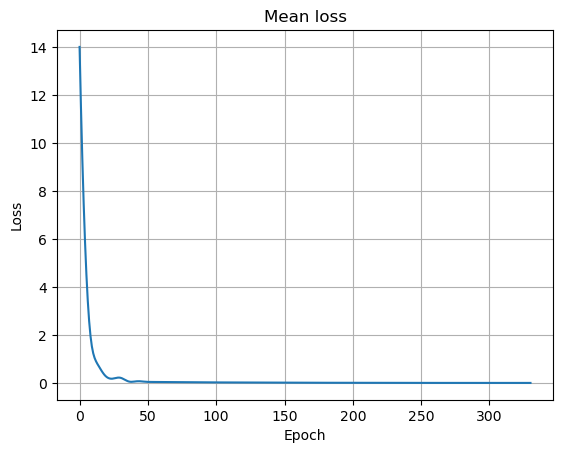

In [24]:
# Setup training and test data configurations
N_of_train_points_1D = 10
N_of_test_points_1D = 101
L_x_1D = 0.0
R_x_1D = 1.0
Dirichlet_left_1D = 0.0
Dirichlet_right_1D = 0.0
loss_threshold_1D = 0.001
Layers_1D = [1, 10, 10, 10, 1] # Adjusted to include input and output layers explicitly
Learning_rate_1D = 0.005

# Prepare the model
model_1D = Puasson1DPINN(Layers_1D, None) # Optimizer will be set up separately in PyTorch

# Setup the optimizer
optimizer_1D = optim.Adam(model_1D.parameters(), lr=Learning_rate_1D)

# Assign the optimizer to the model (if the model class uses it)
model_1D.optimizer = optimizer_1D

# Prepare training and boundary condition data
x_train_1D = torch.linspace(L_x_1D, R_x_1D, N_of_train_points_1D).unsqueeze(-1).float()
x_bc_left_right_1D = torch.tensor([L_x_1D, R_x_1D]).unsqueeze(-1).float()
u_bc_left_right_1D = torch.tensor([Dirichlet_left_1D, Dirichlet_right_1D]).unsqueeze(-1).float()

# Train the model
model_1D.train(loss_threshold_1D, x_train_1D, x_bc_left_right_1D, u_bc_left_right_1D)

In [25]:
def save_and_load_model_1D(model, layers, fileName):
    # Ensure the model is on the CPU for saving
    model.to('cpu')
    
    # Save the model's state dictionary
    torch.save(model.state_dict(), f'{fileName}.pt')

    # Instantiate a new model with the same layers configuration
    # Assuming Puasson1DPINN is initialized with a layers argument
    new_model = Puasson1DPINN(layers)
    
    # Load the state dictionary from the file into the new model
    new_model.load_state_dict(torch.load(f'{fileName}.pt'))

    # Ensure the model is in evaluation mode if it is to be used for inference immediately
    new_model.eval()

    return new_model

#save_and_load_model(model_1D, layers)

In [26]:
def calculate_max_relative_error(u_pred, u_exact):
    return 100 * np.linalg.norm(u_exact - u_pred, np.inf) / np.linalg.norm(u_exact, np.inf)

In [27]:
# Generate test data
x_test_1D = torch.linspace(L_x_1D, R_x_1D, N_of_test_points_1D).unsqueeze(-1).float()

# Make predictions
# Assuming model_1D.forward() is the method for making predictions
# There is no direct .predict() method in PyTorch, so we use .forward() or just call the model
u_pred_1D = model_1D(x_test_1D).detach().numpy().reshape(x_test_1D.shape[0])

# Calculate exact solution
U_exact_1D = model_1D.exact_solution(x_test_1D).detach().numpy()

# Calculate Mean Square Error
print("Mean Square Error: ", np.mean((u_pred_1D - U_exact_1D)**2))

# Calculate and print the relative error
error_percentage = calculate_max_relative_error(torch.tensor(u_pred_1D), torch.tensor(U_exact_1D).flatten())
print(f"Relative error: {error_percentage.item():.2f}%")

Mean Square Error:  0.019834151
Relative error: 0.97%


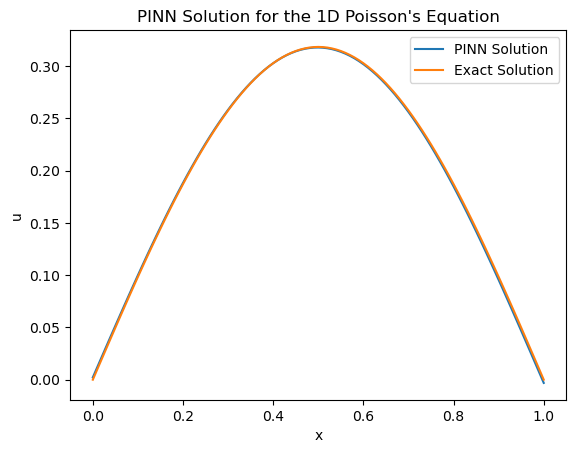

In [28]:
# Plotting
plt.figure()
plt.plot(x_test_1D.numpy(), u_pred_1D, label='PINN Solution')
plt.plot(x_test_1D.numpy(), U_exact_1D, label='Exact Solution')
plt.xlabel('x')
plt.ylabel('u')
plt.title('PINN Solution for the 1D Poisson\'s Equation')
plt.legend()
plt.savefig("1d_poisson_equation_approx_exact_solution_pytorch.png")
plt.show()

In [29]:
class Puasson2DPINN(nn.Module):
    def __init__(self, layers, optimizer):
        super(Puasson2DPINN, self).__init__()
        # Creating a list of hidden layers
        self.hidden_layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.tanh = nn.Tanh()
        self.optimizer = optimizer

    def forward(self, x1_x2):
        for layer in self.hidden_layers[:-1]:
            x1_x2 = self.tanh(layer(x1_x2))
        x1_x2 = self.hidden_layers[-1](x1_x2)  # No activation after the last layer
        return x1_x2

    def compute_gradients(self, x1_x2):
        x1_x2.requires_grad = True
        
        u = self.forward(x1_x2)
        grads = torch.autograd.grad(u, x1_x2, grad_outputs=torch.ones_like(u), create_graph=True)[0]  # Note the [0] to get the first tensor
        u_x1, u_x2 = grads[:, 0], grads[:, 1]

        u_x1_x1 = torch.autograd.grad(u_x1, x1_x2, grad_outputs=torch.ones_like(u_x1), create_graph=True)[0][:, 0]
        u_x2_x2 = torch.autograd.grad(u_x2, x1_x2, grad_outputs=torch.ones_like(u_x2), create_graph=True)[0][:, 1]

        return u, u_x1, u_x2, u_x1_x1, u_x2_x2

    def dirichlet_condition(self, x1_x2_bc_up, x1_x2_bc_down, u_bc_up, u_bc_down):
        u_up, _, _, _, _ = self.compute_gradients(x1_x2_bc_up)
        u_down, _, _, _, _ = self.compute_gradients(x1_x2_bc_down)
        # Assuming u_bc_up and u_bc_down are each of shape [10, 1] and need to be concatenated to match u's shape
        return torch.mean((u_up - u_bc_up)**2) + torch.mean((u_down - u_bc_down)**2)

    def neuman_condition(self, x1_x2_bc_left, x1_x2_bc_right):
        u_left, u_x1_left, _, _, _ = self.compute_gradients(x1_x2_bc_left)
        _, u_x1_right, _, _, _ = self.compute_gradients(x1_x2_bc_right)
        return torch.mean((-u_x1_left - u_left)**2) + torch.mean((u_x1_right)**2) # Assuming specific boundary condition implementation

    def loss_fn(self, x1_x2_train, u_x1_x1, u_x2_x2, x1_x2_bc_left, x1_x2_bc_right, x1_x2_bc_up, x1_x2_bc_down, u_bc_up, u_bc_down):
        _, _, _, u_x1_x1_pred, u_x2_x2_pred = self.compute_gradients(x1_x2_train)
        puasson_eq = u_x1_x1_pred + u_x2_x2_pred - self.f(x1_x2_train)
        bc_dirichlet = self.dirichlet_condition(x1_x2_bc_up, x1_x2_bc_down, u_bc_up, u_bc_down)
        bc_neuman = self.neuman_condition(x1_x2_bc_left, x1_x2_bc_right)

        return torch.mean(torch.square(puasson_eq)) + (bc_dirichlet + 10 * bc_neuman)

    def train_loop(self, loss_threshold, x1_x2_train, x1_x2_bc_left, x1_x2_bc_right, x1_x2_bc_up, x1_x2_bc_down, u_bc_up, u_bc_down):
        loss_array = []
        start_time = time.time()

        loss = torch.tensor(1.0)
        epoch = 0
        try:
            while loss.item() > loss_threshold:
                self.optimizer.zero_grad()
                loss = self.loss_fn(x1_x2_train, None, None, x1_x2_bc_left, x1_x2_bc_right, x1_x2_bc_up, x1_x2_bc_down, u_bc_up, u_bc_down)
                loss.backward()
                self.optimizer.step()

                loss_array.append(loss.item())
                if epoch % 100 == 0:
                    print(f'Epoch {epoch}, Loss: {loss.item()}')
                epoch += 1
        except KeyboardInterrupt:
                print("Training stopped manually")
        print("Training took %s seconds" % (time.time() - start_time))
        print(f"Last epoch: {epoch}, loss: {loss.item()}")

        plt.plot(loss_array)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.title('Mean loss during training')
        plt.savefig("2d_poisson_equation_training.png")
        plt.show(block=False)

    def f(self, x1_x2):
        x1, x2 = x1_x2[:, 0], x1_x2[:, 1]
        return -np.pi * torch.sin(np.pi * x1) * torch.sin(np.pi * x2)

Epoch 0, Loss: 2.3734095096588135
Epoch 100, Loss: 0.19941020011901855
Epoch 200, Loss: 0.08044758439064026
Epoch 300, Loss: 0.0557994470000267
Epoch 400, Loss: 0.04740430787205696
Epoch 500, Loss: 0.04379861056804657
Epoch 600, Loss: 0.04105059802532196
Epoch 700, Loss: 0.038819819688797
Epoch 800, Loss: 0.03810200095176697
Epoch 900, Loss: 0.0374889001250267
Epoch 1000, Loss: 0.11384977400302887
Epoch 1100, Loss: 0.03690062090754509
Epoch 1200, Loss: 0.036635622382164
Epoch 1300, Loss: 0.03713119775056839
Epoch 1400, Loss: 0.03627526015043259
Epoch 1500, Loss: 0.036424972116947174
Epoch 1600, Loss: 0.03602031245827675
Epoch 1700, Loss: 0.03585854917764664
Epoch 1800, Loss: 0.03570991009473801
Epoch 1900, Loss: 0.03567400202155113
Epoch 2000, Loss: 0.03553188592195511
Epoch 2100, Loss: 0.03540603071451187
Epoch 2200, Loss: 0.035352569073438644
Epoch 2300, Loss: 0.03521741181612015
Epoch 2400, Loss: 0.037351347506046295
Epoch 2500, Loss: 0.0350806899368763
Epoch 2600, Loss: 0.034990571

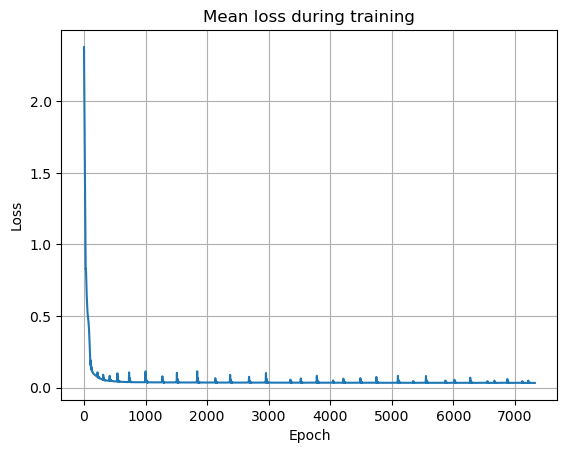

In [30]:
# Constants
N_of_train_points_2D = 100
N_of_test_points_2D = 101
L_x1_2D = 0.0
R_x1_2D = 1.0
L_x2_2D = 0.0
R_x2_2D = 1.0
Dirichlet_up_2D = 0.0
Dirichlet_down_2D = 0.0
loss_threshold_2D = 0.001
Layers_2D = [2, 70, 70, 70, 1]  # Adjusted for PyTorch: (input_size, output_size)
Learning_rate_2D = 0.001

# Initialize model and optimizer
model_2D = Puasson2DPINN(Layers_2D, None)  # Optimizer will be set up separately
optimizer_2D = optim.AdamW(model_2D.parameters(), lr=Learning_rate_2D)
model_2D.optimizer = optimizer_2D  # Assuming your class can accept an optimizer like this

# Training and test data preparation
x1_train = np.linspace(L_x1_2D, R_x1_2D, N_of_train_points_2D)
x2_train = np.linspace(L_x2_2D, R_x2_2D, N_of_train_points_2D)
X, T = np.meshgrid(x1_train, x2_train)
x1_x2_train = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
x1_x2_train = torch.tensor(x1_x2_train, dtype=torch.float32)

# Boundary conditions preparation
# bc - boundary condition (left and right) neuman
#         __________________________
#         ||                       ||
# [-1, 0] || x2                    || [1, 0] 
#         ||          x1           ||
#         ||_______________________||
# ∂u/∂n = -∂u/∂x1                      ∂u/∂n = ∂u/∂x1
x1_bc_left = L_x1_2D * np.ones_like(x2_train)
x1_bc_right = R_x1_2D * np.ones_like(x2_train)
x1_x2_bc_left = np.hstack((L_x1_2D * np.ones_like(x1_train)[:, None], x2_train[:, None]))
x1_x2_bc_right = np.hstack((R_x1_2D * np.ones_like(x1_train)[:, None], x2_train[:, None]))
x1_x2_bc_left = torch.tensor(x1_x2_bc_left, dtype=torch.float32)
x1_x2_bc_right = torch.tensor(x1_x2_bc_right, dtype=torch.float32)

# bc - boundary condition (up and down) dirichlet
#          [0, 1]  ∂u/∂n = ∂u/∂x2
#  =======================
# |                       |
# | x2                    |
# |          x1           |
# |=======================|
#          [0, -1]  ∂u/∂n = -∂u/∂x2
x2_bc_up = L_x1_2D * np.ones_like(x1_train)
x2_bc_down = R_x1_2D * np.ones_like(x1_train)
x1_x2_bc_up = np.hstack((x1_train[:, None], R_x2_2D * np.ones_like(x2_train)[:, None]))
x1_x2_bc_down = np.hstack((x1_train[:, None], L_x2_2D * np.ones_like(x2_train)[:, None]))
x1_x2_bc_up = torch.tensor(x1_x2_bc_up, dtype=torch.float32)
x1_x2_bc_down = torch.tensor(x1_x2_bc_down, dtype=torch.float32)

u_bc_up = Dirichlet_up_2D * np.ones_like(x1_train)
u_bc_down = Dirichlet_down_2D * np.ones_like(x1_train)
u_bc_up = torch.tensor(u_bc_up, dtype=torch.float32)
u_bc_down = torch.tensor(u_bc_down, dtype=torch.float32)

# Training
model_2D.train_loop(loss_threshold_2D, x1_x2_train, x1_x2_bc_left, x1_x2_bc_right, x1_x2_bc_up, x1_x2_bc_down, u_bc_up, u_bc_down)

In [31]:
def save_and_load_model_2D(model, layers, optimizer_cls, optimizer_kwargs, fileName):
    # Ensure the model is on the CPU for saving
    model.to('cpu')
    
    # Save model state dictionary
    torch.save(model.state_dict(), f'{fileName}.pt')

    # Instantiate a new model with the same configuration
    new_model = Puasson2DPINN(layers, optimizer_cls(**optimizer_kwargs))

    # Load the state dict into the new model
    new_model.load_state_dict(torch.load(f'{fileName}.pt'))

    # Make sure to call .eval() if you're loading the model for inference
    new_model.eval()

    return new_model

#save_and_load_model_2D(model, layers)

In [32]:
# Assuming L_x1_2D, R_x1_2D, L_x2_2D, R_x2_2D, and N_of_test_points_2D are predefined
x1_test = np.linspace(L_x1_2D, R_x1_2D, N_of_test_points_2D)
x2_test = np.linspace(L_x2_2D, R_x2_2D, N_of_test_points_2D)
x1_mesh, x2_mesh = np.meshgrid(x1_test, x2_test)
x1x2_test = np.hstack((x1_mesh.flatten()[:, np.newaxis], x2_mesh.flatten()[:, np.newaxis]))

# Convert numpy arrays to PyTorch tensors
x1x2_test_tensor = torch.tensor(x1x2_test, dtype=torch.float32)

# Make sure the model is in evaluation mode
model_2D.eval()

# Get predictions from the model
with torch.no_grad():
    u_pred_tensor = model_2D(x1x2_test_tensor)

# Reshape the predictions to match the meshgrid shape
u_pred = u_pred_tensor.reshape(x1_test.shape[0], x2_test.shape[0]).numpy()

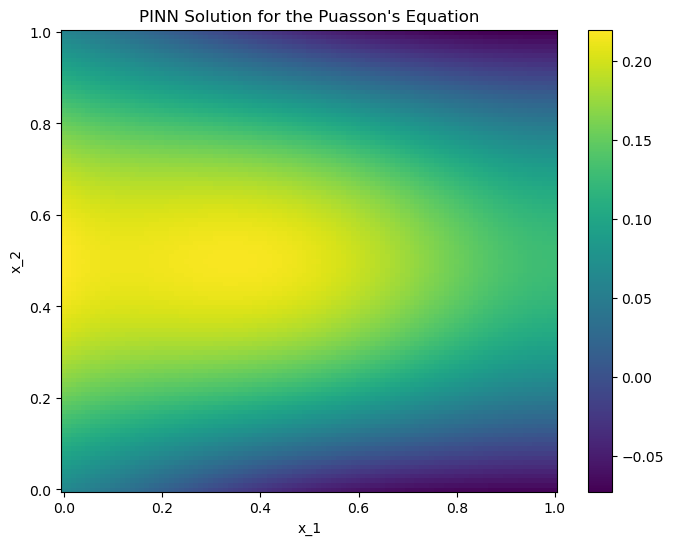

In [33]:
# Visualization
plt.figure(figsize=(8, 6))
plt.pcolor(x1_mesh, x2_mesh, u_pred, cmap='viridis')
plt.colorbar()
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title("PINN Solution for the Puasson's Equation")
plt.savefig("2d_poisson_equation_exact_solution_heatmap_pytorch.png")
plt.show(block=False)

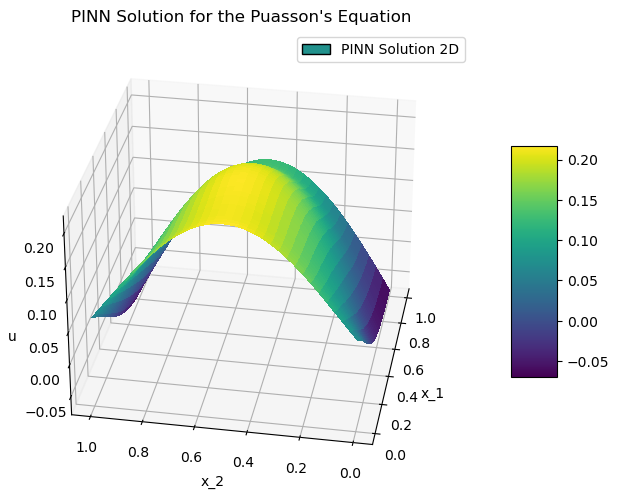

In [34]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x1_mesh, x2_mesh, u_pred, cmap='viridis', linewidth=0, antialiased=False)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('u')
ax.set_title("PINN Solution for the Puasson's Equation")
color_for_legend = cm.viridis(0.5)
proxy = Rectangle((0, 0), 1, 1, fc=color_for_legend, edgecolor="k")
ax.legend([proxy], ['PINN Solution 2D'])
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=30, azim=190)
plt.savefig("2d_poisson_equation_approx_solution_pytorch.png")
plt.show()

In [35]:
def calculate_max_relative_error(u_pred, u_exact):
    max_diff_index = np.argmax(u_exact - u_pred)
    print("Max difference index:", max_diff_index)
    difference = u_exact - u_pred
    # Find the flattened index of the maximum difference
    max_diff_index_flattened = np.argmax(np.abs(difference))

    # Convert the flattened index to 2D row and column indices
    max_diff_row, max_diff_col = np.unravel_index(max_diff_index_flattened, difference.shape)
    print(f"Row: {max_diff_row}, column: {max_diff_col}")

    # Display the maximum difference
    print("Max difference:", np.abs(difference[max_diff_row, max_diff_col]))

    # Display the elements from both arrays corresponding to the maximum difference
    print("Element from u_exact with max difference:", u_exact[max_diff_row, max_diff_col])
    print("Element from u_pred with max difference:", u_pred[max_diff_row, max_diff_col])
    return 100 * np.linalg.norm(u_exact - u_pred, np.inf) / np.linalg.norm(u_exact, np.inf)

Solving linear variational problem.


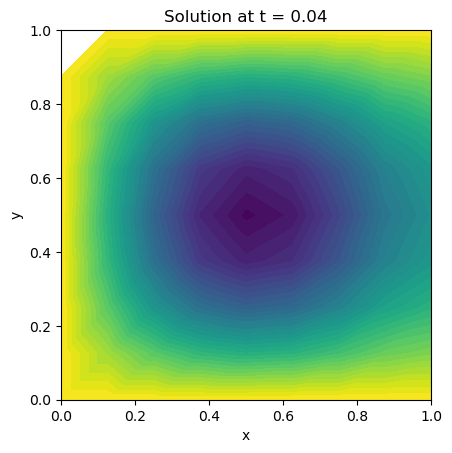

Solving linear variational problem.


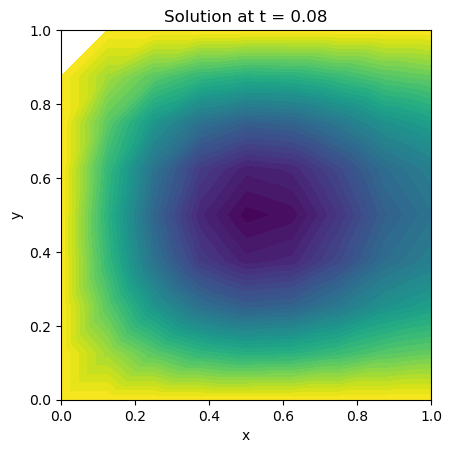

Solving linear variational problem.


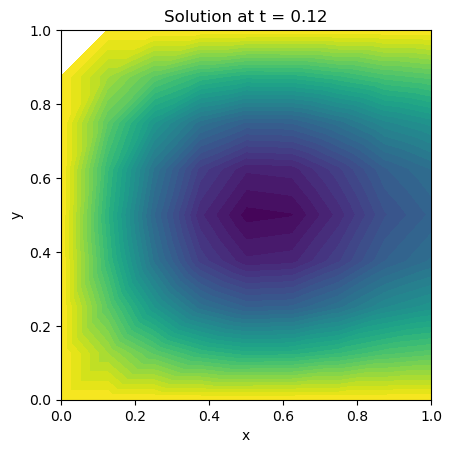

Solving linear variational problem.


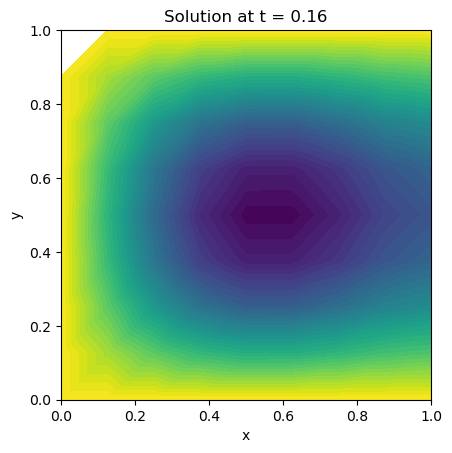

Solving linear variational problem.


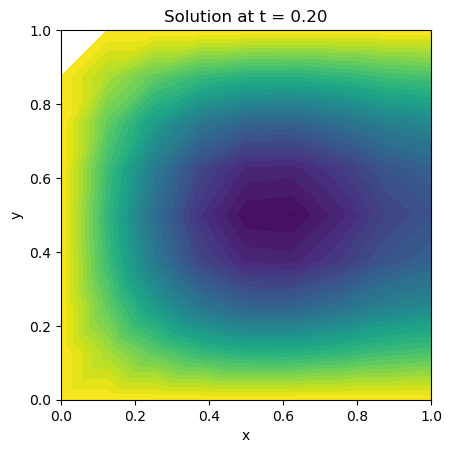

Solving linear variational problem.


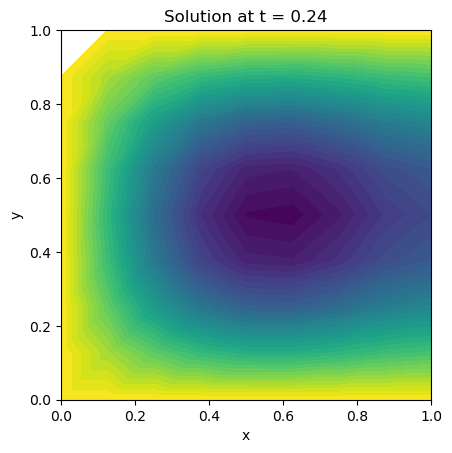

Solving linear variational problem.


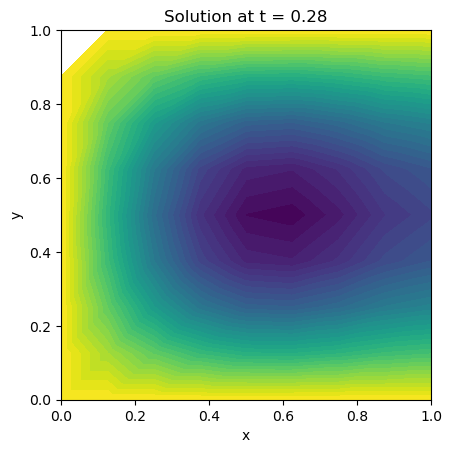

Solving linear variational problem.


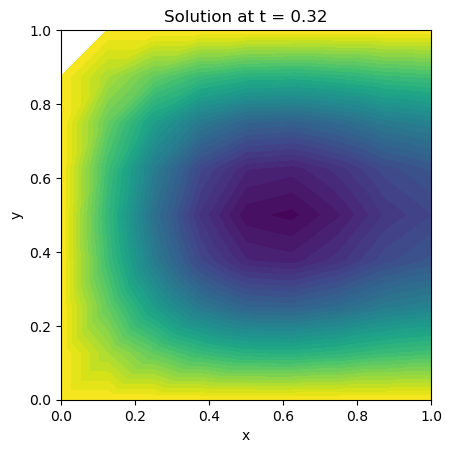

Solving linear variational problem.


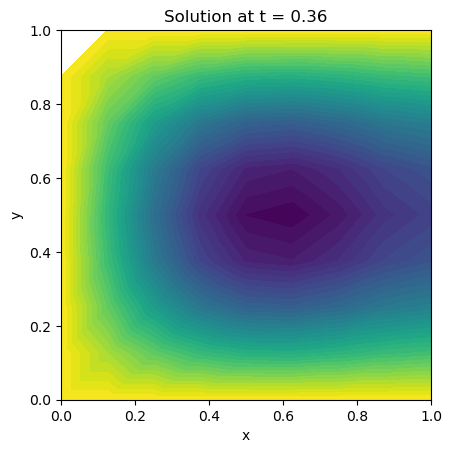

Solving linear variational problem.


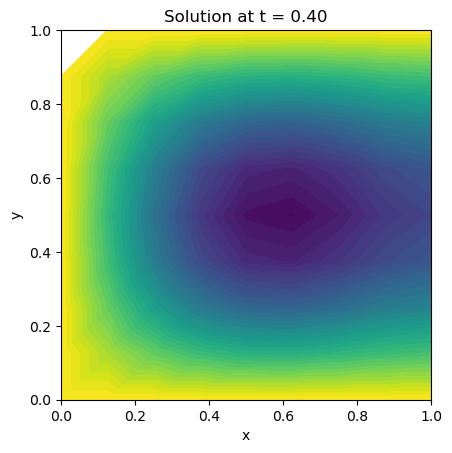

Solving linear variational problem.


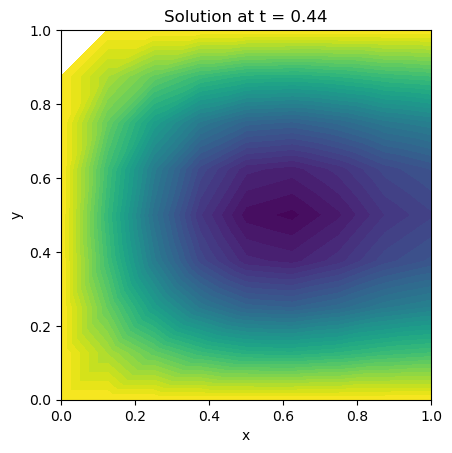

Solving linear variational problem.


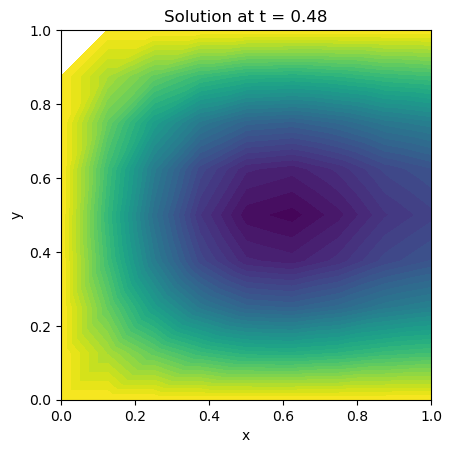

Solving linear variational problem.


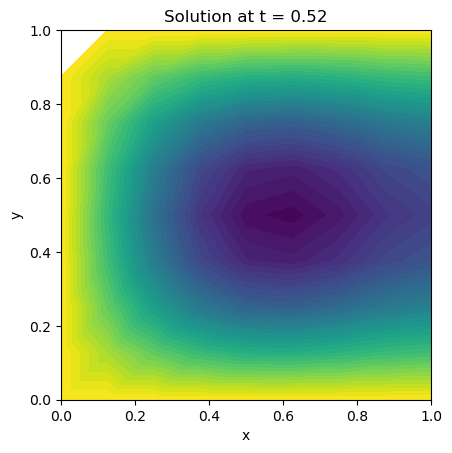

Solving linear variational problem.


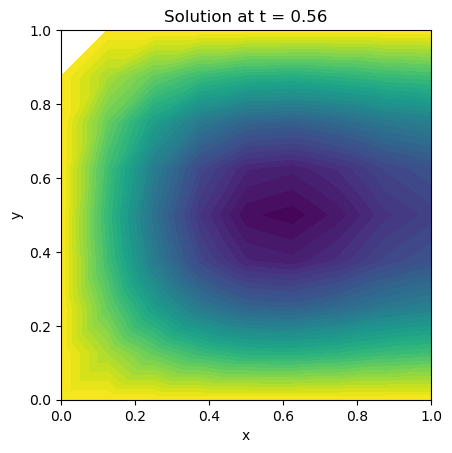

Solving linear variational problem.


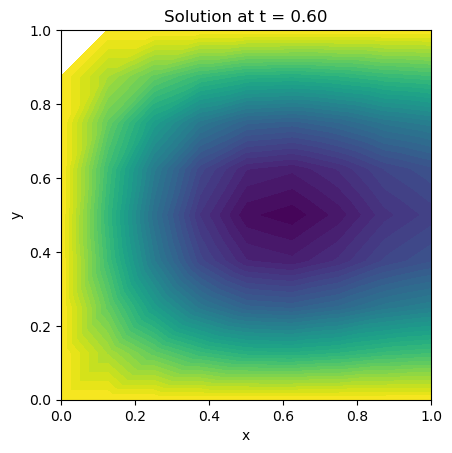

Solving linear variational problem.


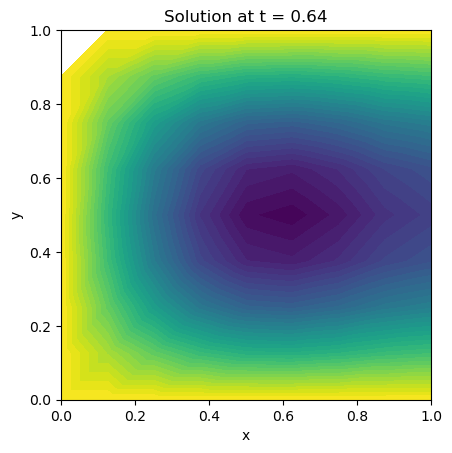

Solving linear variational problem.


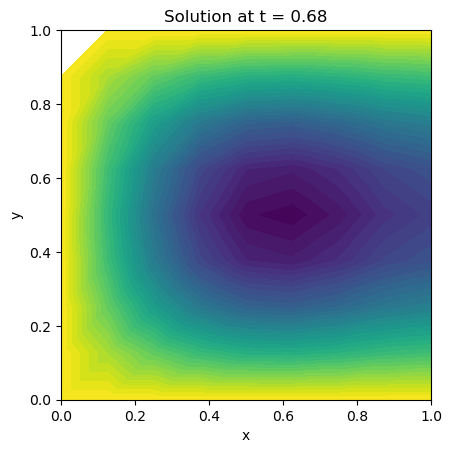

Solving linear variational problem.


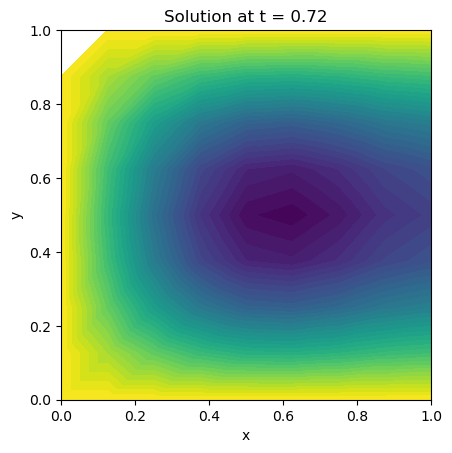

Solving linear variational problem.


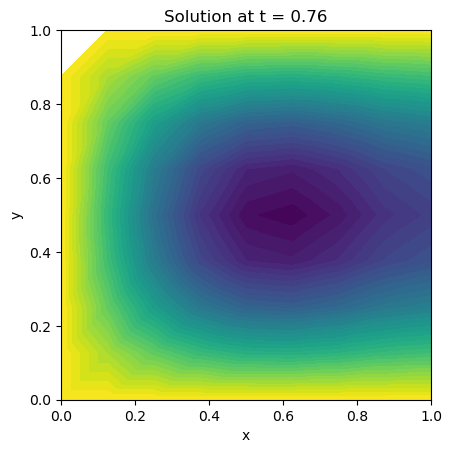

Solving linear variational problem.


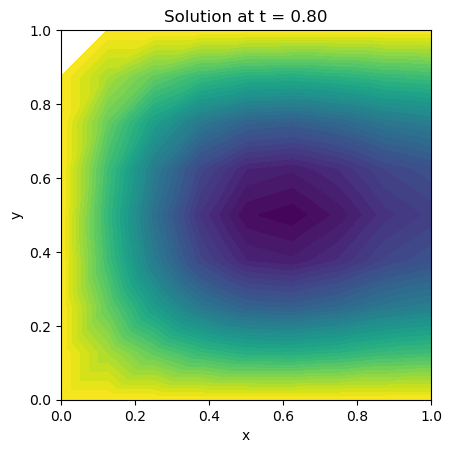

Solving linear variational problem.


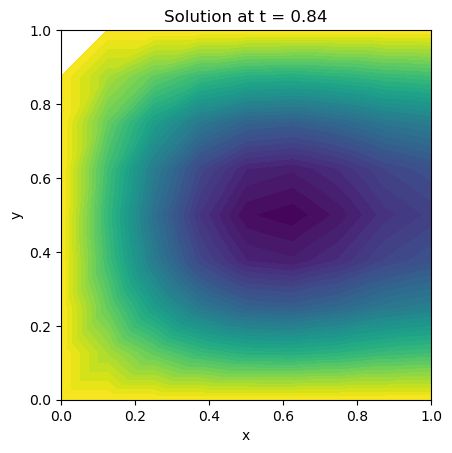

Solving linear variational problem.


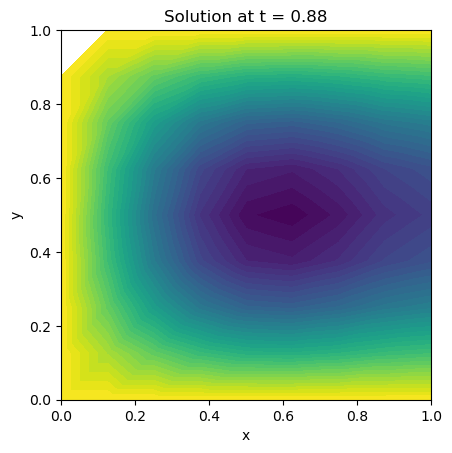

Solving linear variational problem.


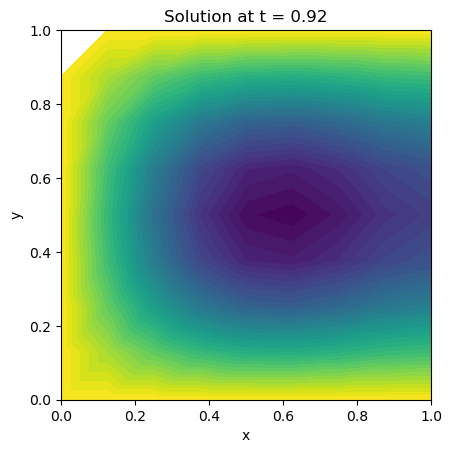

Solving linear variational problem.


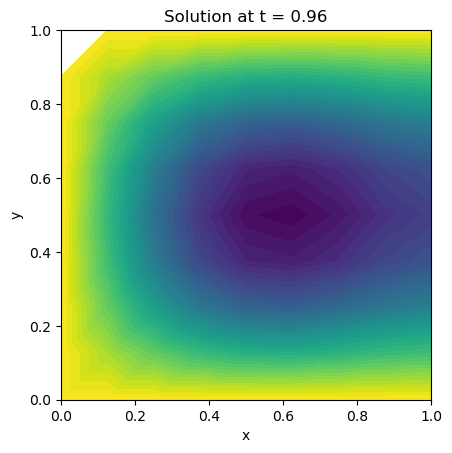

Solving linear variational problem.


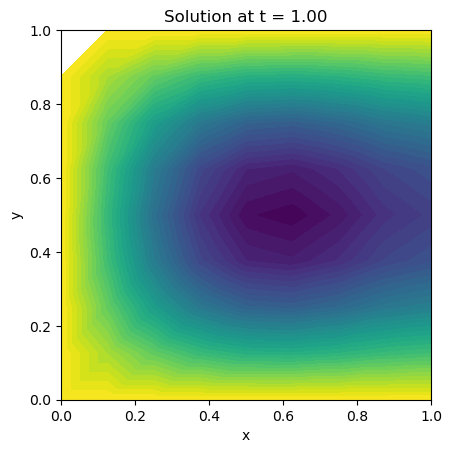

Solving linear variational problem.


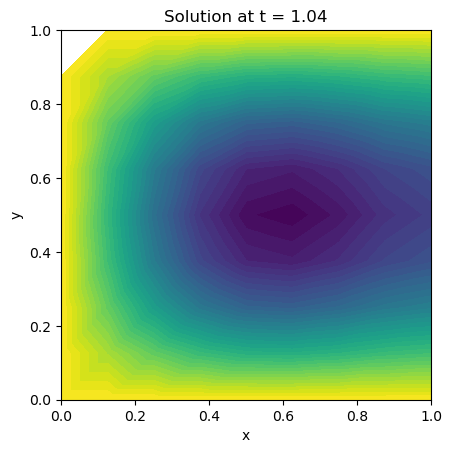

Solving linear variational problem.


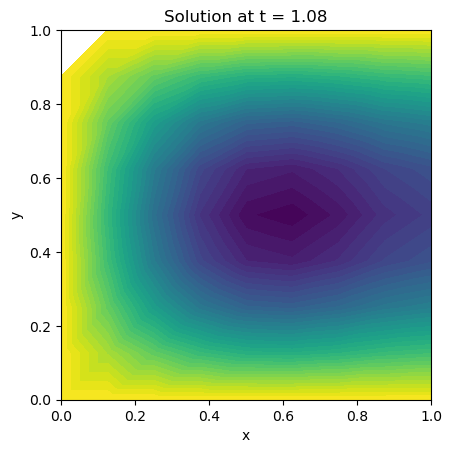

Solving linear variational problem.


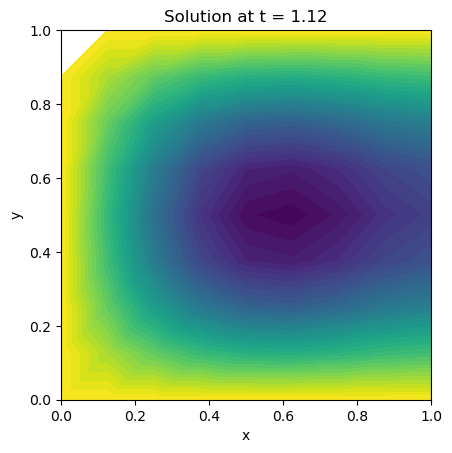

Solving linear variational problem.


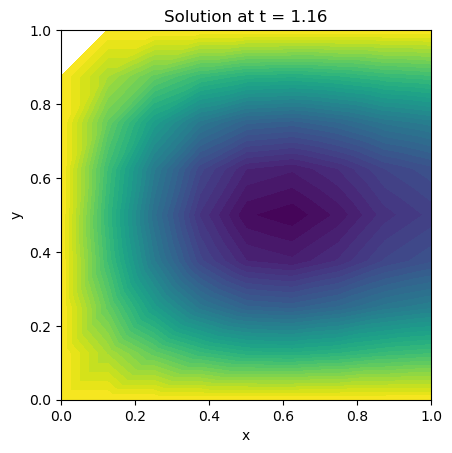

Solving linear variational problem.


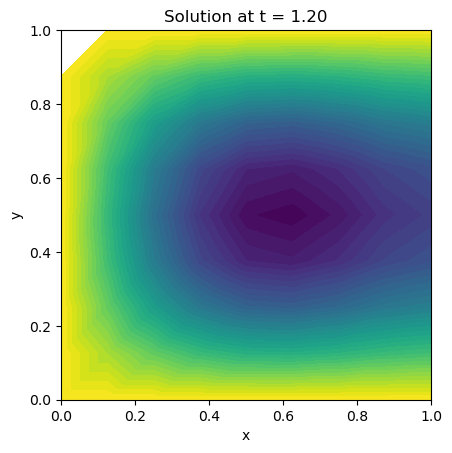

Solving linear variational problem.


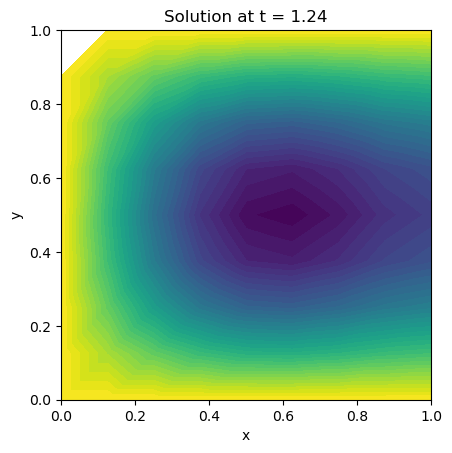

Solving linear variational problem.


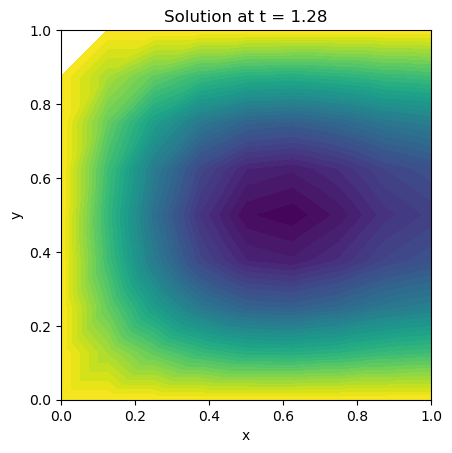

Solving linear variational problem.


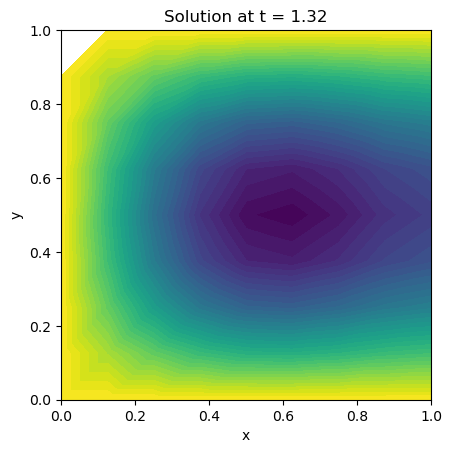

Solving linear variational problem.


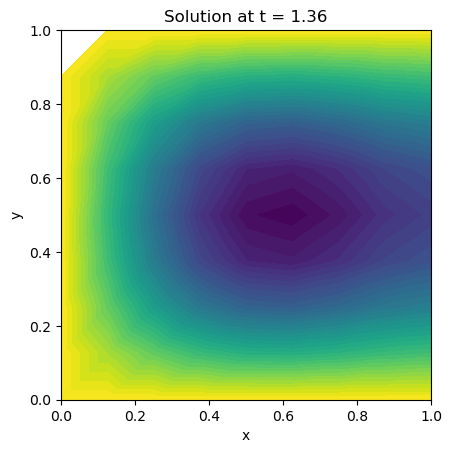

Solving linear variational problem.


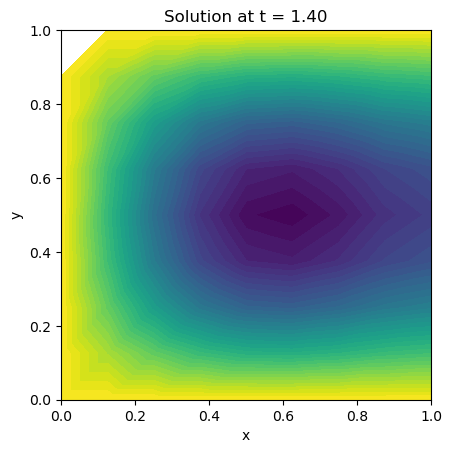

Solving linear variational problem.


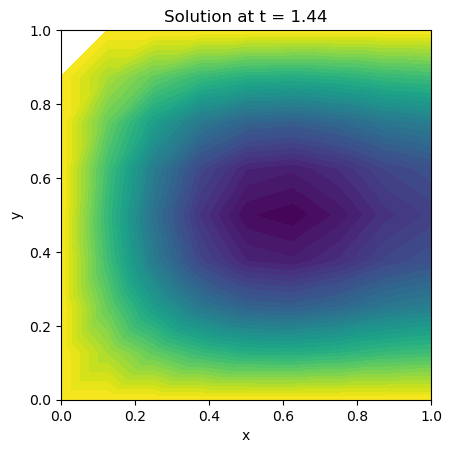

Solving linear variational problem.


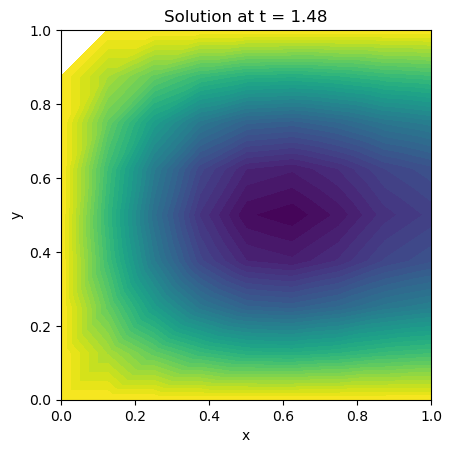

Solving linear variational problem.


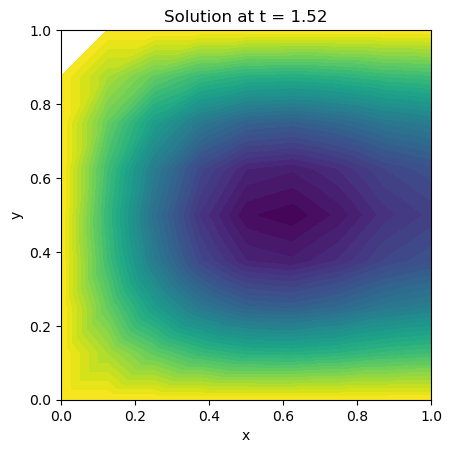

Solving linear variational problem.


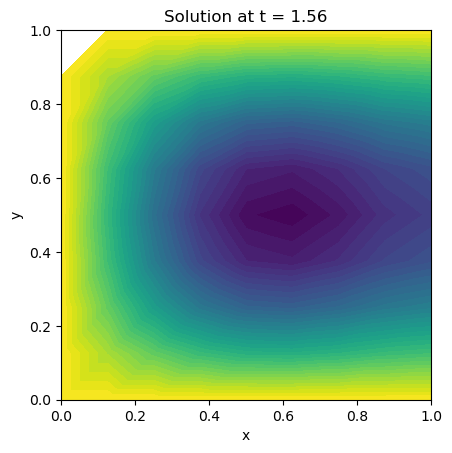

Solving linear variational problem.


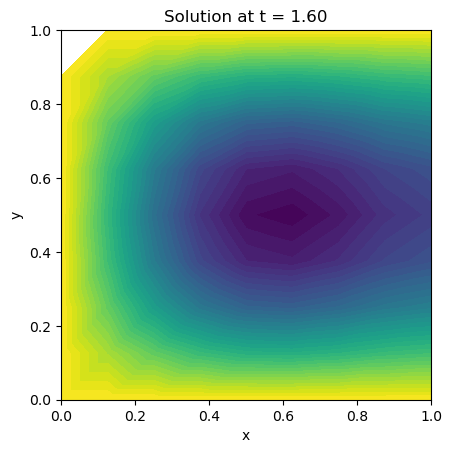

Solving linear variational problem.


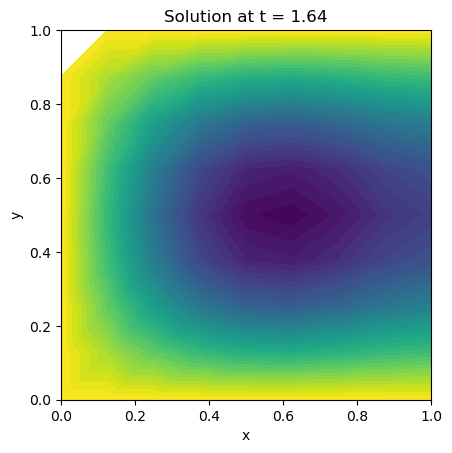

Solving linear variational problem.


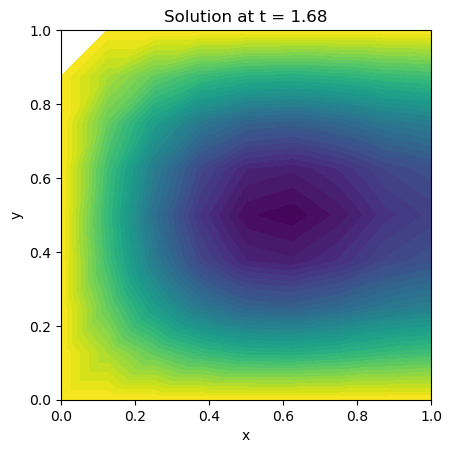

Solving linear variational problem.


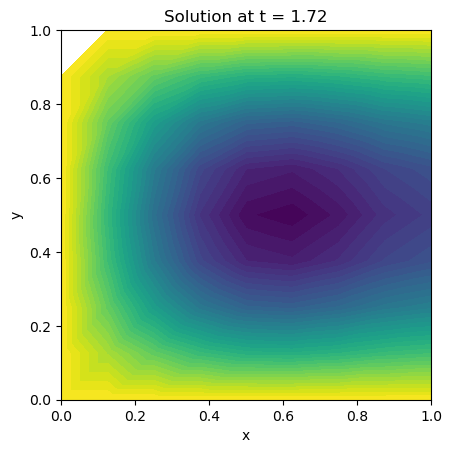

Solving linear variational problem.


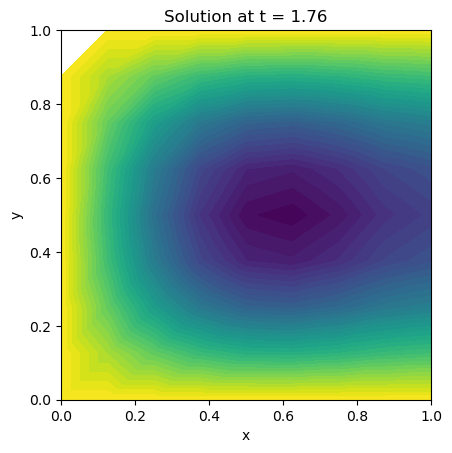

Solving linear variational problem.


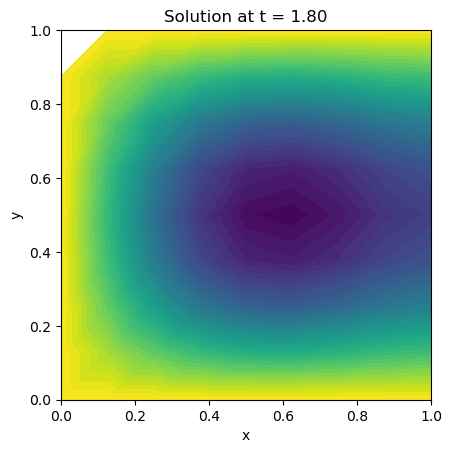

Solving linear variational problem.


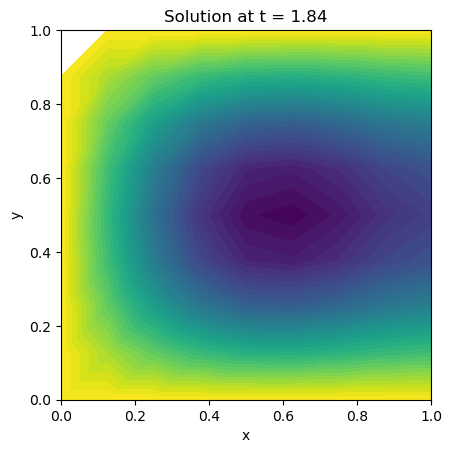

Solving linear variational problem.


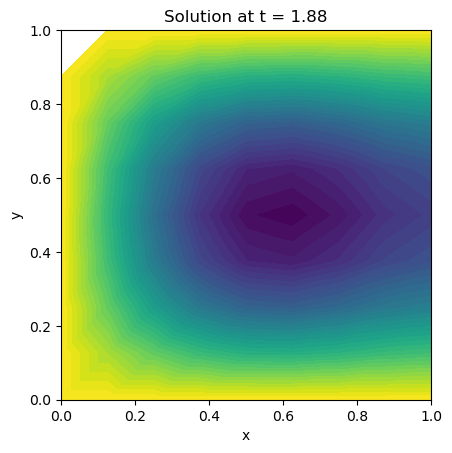

Solving linear variational problem.


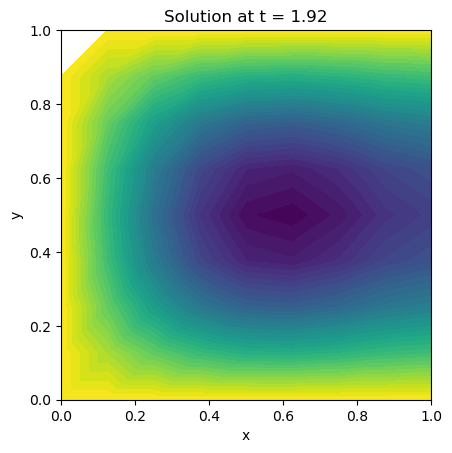

Solving linear variational problem.


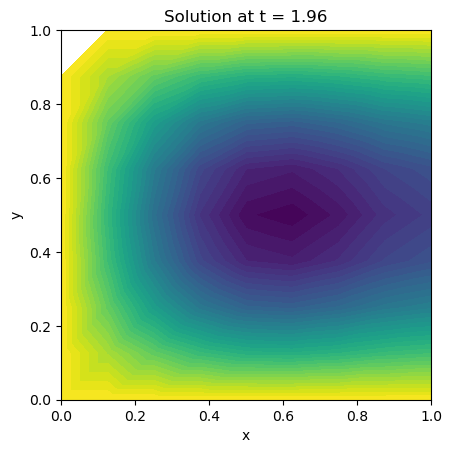

Solving linear variational problem.


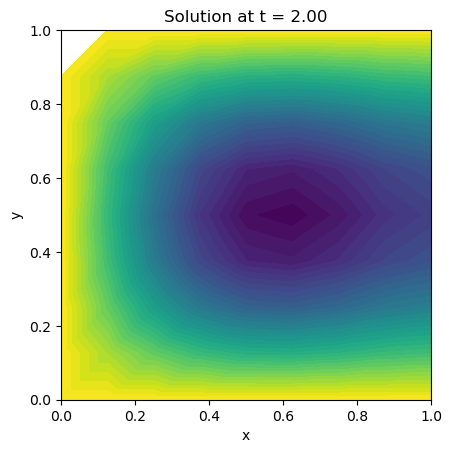

CODE BELOW IS INCORRECT FOR NON-STATIONARY PROBLEM

Solving useing FEM
Solving linear variational problem.


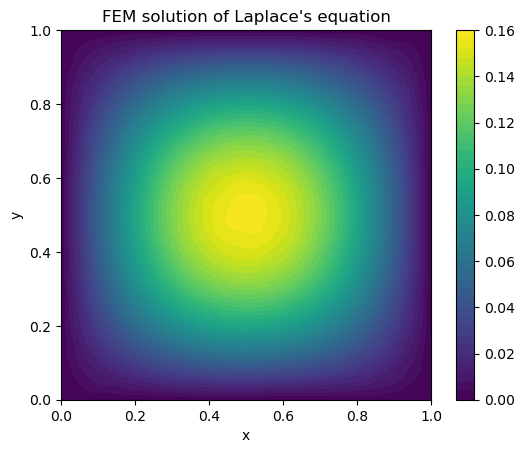

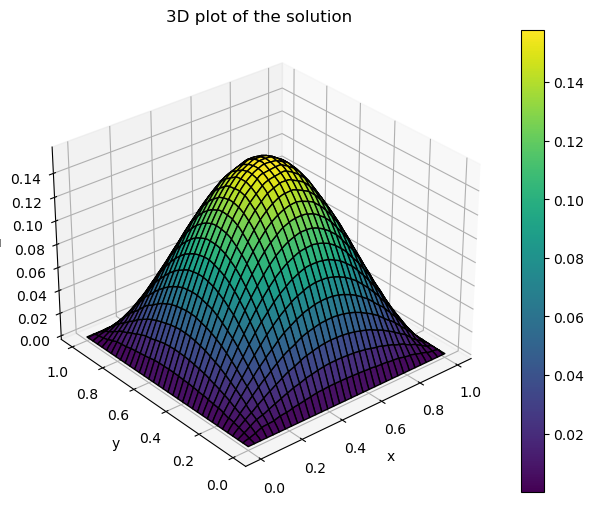

Mean Squared Error (PINN and FEM): 0.0054274861095769105
Max difference index: 5050
Row: 50, column: 0
Max difference: 0.21952387690544128
Element from u_exact with max difference: 0.21952388
Element from u_pred with max difference: 0.0
Relative error (PINN and FEM): 47.49%


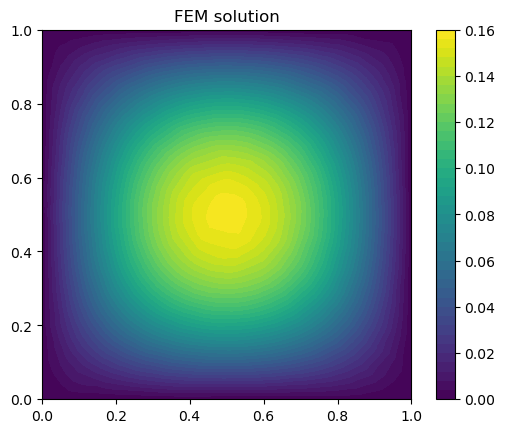

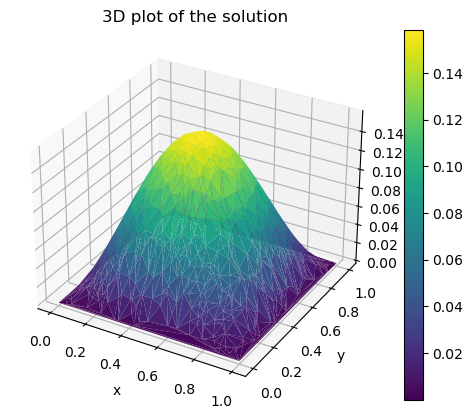

In [40]:
print("Solving useing FEM")

import numpy as np
from scipy.spatial import Delaunay

n_interior_points = 1000  # Number of interior points to generate
interior_points = np.random.rand(n_interior_points, 2)
x_max = y_max = 1
x_min = y_min = 0

corners = np.array([
    [x_min, y_min],  # Bottom left corner
    [x_max, y_min],  # Bottom right corner
    [x_max, y_max],  # Top right corner
    [x_min, y_max]   # Top left corner
])

interior_points[:, 0] = interior_points[:, 0] * (x_max - x_min) + x_min
interior_points[:, 1] = interior_points[:, 1] * (y_max - y_min) + y_min
points = np.vstack([corners, interior_points])
tri = Delaunay(points)

from fenics import *
import matplotlib.pyplot as plt
import numpy as np

mesh = Mesh()
editor = MeshEditor()
editor.open(mesh, "triangle", 2, 2)
editor.init_vertices(len(points))
for i, vertex in enumerate(points):
    editor.add_vertex(i, vertex)
editor.init_cells(len(tri.simplices))
for i, simplex in enumerate(tri.simplices):
    editor.add_cell(i, simplex)
editor.close()

V = FunctionSpace(mesh, 'P', 1)
n = FacetNormal(mesh)


# Create mesh and define function space
nx, ny = 10, 10

# Define boundary conditions
def boundary_upper(x, on_boundary):
    return on_boundary and near(x[1], R_x1_2D)

def boundary_lower(x, on_boundary):
    return on_boundary and near(x[1], L_x1_2D)

class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0)

bc_upper = DirichletBC(V, Constant(Dirichlet_up_2D), boundary_upper)
bc_lower = DirichletBC(V, Constant(Dirichlet_down_2D), boundary_lower)

# Initialize mesh function for boundary domains
boundaries = MeshFunction('size_t', mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
left_boundary = LeftBoundary()
left_boundary.mark(boundaries, 1)

# Define measure for integrating over boundaries
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

bcs = [bc_upper, bc_lower]

# Define problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression('-pi * sin(pi * x[0]) * sin(pi * x[1])', degree=2)
alpha_c = Constant(1)
g = Constant(0)
a = -dot(grad(u), grad(v))*dx + alpha_c*u*v*ds(1) + dot(grad(u), n)*v*ds(1)
L = f*v*dx + g*v*ds(1)

# Compute solution
u_fenics_app = Function(V)
solve(a == L, u_fenics_app, bcs)

# Plot solution using matplotlib
c = plot(u_fenics_app)
plt.colorbar(c)
plt.title("FEM solution of Laplace's equation")
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('fenics_solution_half_dirichlet_Laplace_heatmap.png')
plt.show()

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(L_x1_2D, R_x1_2D, N_of_test_points_2D)
y = np.linspace(L_x2_2D, R_x2_2D, N_of_test_points_2D)
X, Y = np.meshgrid(x, y)
points = np.vstack((X.ravel(), Y.ravel())).T

# Initialize an array to store the solution
u_fenics = np.zeros_like(points[:, 0])

# Evaluate the FEniCS solution at each point
for i, point in enumerate(points):
    u_fenics[i] = u_fenics_app(point)

# Reshape the solution to a 2D grid for plotting or comparison
u_fenics_grid = u_fenics.reshape((len(x), len(y)))

surf = ax.plot_surface(X, Y, u_fenics_grid, cmap='viridis', edgecolor='k')
plt.colorbar(surf)
plt.title("3D plot of the solution")
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('u')
ax.view_init(elev=30, azim=-130)
plt.savefig('fenics_solution_half_dirichlet_Laplace_3D.png')
plt.show()

print("Mean Squared Error (PINN and FEM):", np.mean((u_fenics_grid - u_pred)**2))

relative_error = calculate_max_relative_error(u_fenics_grid, u_pred)
print(f"Relative error (PINN and FEM): {relative_error:.2f}%")



c = plot(u_fenics_app)
plt.colorbar(c)
plt.title("FEM solution")
plt.show()

# Evaluate solution at mesh vertices for 3D plotting
x = mesh.coordinates()[:, 0]
y = mesh.coordinates()[:, 1]
u_fenics = np.array([u_fenics_app(point) for point in mesh.coordinates()])

# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(x, y, u_fenics, cmap='viridis', edgecolor='none')
plt.colorbar(surf)
plt.title("3D plot of the solution")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
plt.show()

